<a href="https://colab.research.google.com/github/mtermor/NTIC_DeepLearning/blob/main/NLP/tarea1_nlp_MTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificaton Fine-tuning

La siguiente tarea consiste en entrenar un modelo de HuggingFace (HF) para realizar la _task_ de _classification_. El dataset para entrenar dicho modelo está predefinido. Sin embargo, el modelo, el tokenizador y el trainer pueden ser totalmente personalizados. Es decir, que tendréis que realizar un trabajo de investigación, de prueba y error, para poder ir aprendiendo y ganando destreza con HF.

Recomendaciones:
- Durante este proceso, tendréis muchas dudas y encontraréis muchos errores. Tratad de resolverlas primero por vuestra cuenta, enteniendo la causa del error. Después con recursos online. Y, finalmente, siempre está el foro, que puede ser utilizado de forma participativa.
- No dejeis la tarea para el último día. Los modelos tardan en entrenar. Los problemas no se resuelven en la primera iteración.

Finalmente, se pide:
- Limpieza rigurosa en la presentación del notebook.
- El notebook se entrega con todas las celdas ejecutadas.
- Los comentarios (opcionales), mejor sobre el código con '#'.

Ánimo!

## Dataset

A continuación, descargarás un DatasectDict llamado _glue_. La target es la columna llamada _label_.

In [1]:
#!pip install datasets

In [2]:
from datasets import load_dataset

ds = load_dataset("glue", "mnli")
ds

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

Lo primero que tendrás que hacer es construir un DatasetDict nuevo, llamado **ds_tarea**, que filtre el anterior DatasetDict para:
- quedarse con los registros que tengan el contenido de la columna _context_ con menos (estrictamente) de 20 caracteres.
- que solo tenga los Datasets de _train_ y _validation_matched_

In [3]:
ds_tarea = None

### BEGIN SOLUTION
from datasets import DatasetDict

filtered_datasets = {}
for split in ds.keys():
    if split == 'train' or split == 'validation_matched':
        filtered_dataset = ds[split].filter(lambda example: len(example['premise']) < 20)
        filtered_datasets[split] = filtered_dataset

ds_tarea = DatasetDict(filtered_datasets)

### END SOLUTION

ds_tarea

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 413
    })
})

In [4]:
# Celda de control

assert len(ds_tarea['train']) == 13635
assert len(ds_tarea['validation_matched']) == 413
assert set(ds_tarea.keys()) == {'train', 'validation_matched'}

## EDA

Si tenéis que realizar alguna exploración del datos, utilizad esta sección.

In [5]:
# Celdas de libre uso

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

In [7]:
## RESUMEN DESCRIPTIVO
# Recuento de registros en cada conjunto de datos
for split in ds_tarea.keys():
    print(f"{split} tiene {ds_tarea[split].num_rows} registros")

# Tipos de datos y características de cada columna
for split in ds_tarea.keys():
    print(f"\nCaracterísticas del conjunto de datos {split}:")
    print(ds_tarea[split].features)

train tiene 13635 registros
validation_matched tiene 413 registros

Características del conjunto de datos train:
{'premise': Value(dtype='string', id=None), 'hypothesis': Value(dtype='string', id=None), 'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None), 'idx': Value(dtype='int32', id=None)}

Características del conjunto de datos validation_matched:
{'premise': Value(dtype='string', id=None), 'hypothesis': Value(dtype='string', id=None), 'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None), 'idx': Value(dtype='int32', id=None)}


In [8]:
## VISUALIZAR EJEMPLOS DE DATOS

print("Ejemplo de entrenamiento:")
print(ds_tarea['train'][0])

print("\nEjemplo de validación matched:")
print(ds_tarea['validation_matched'][0])


Ejemplo de entrenamiento:
{'premise': 'Gays and lesbians.', 'hypothesis': 'Heterosexuals.', 'label': 2, 'idx': 8}

Ejemplo de validación matched:
{'premise': 'Tuppence rose.', 'hypothesis': 'Tuppence floated into the air.', 'label': 1, 'idx': 65}


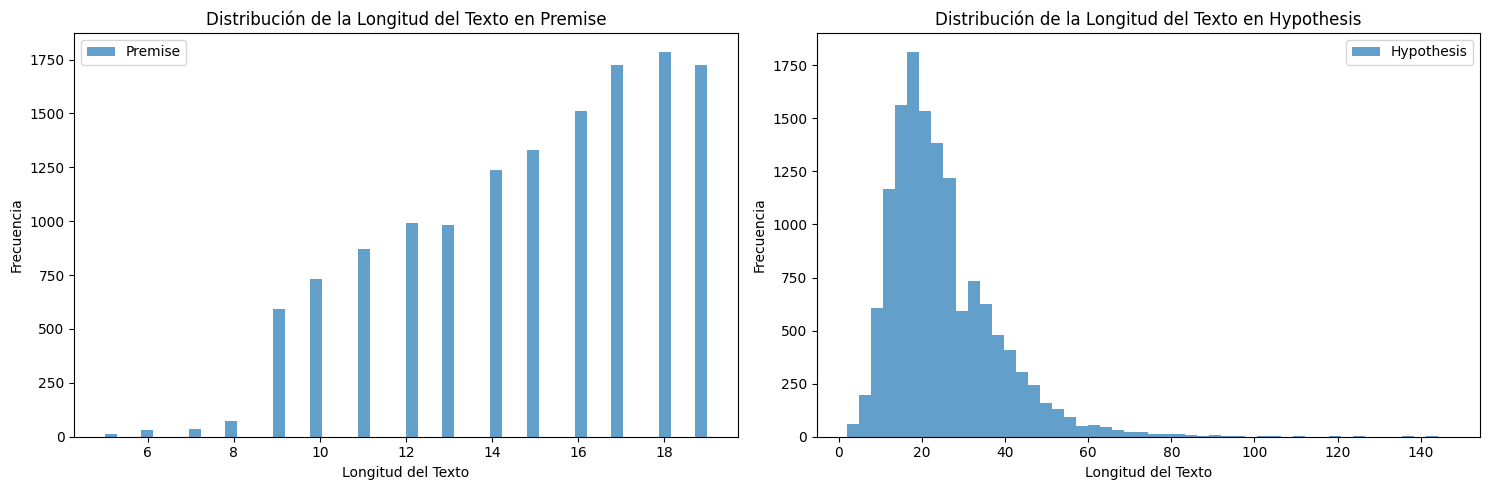

In [9]:
## DISTRIBUCIÓN DE LA LONGITUD DEL TEXTO
# Análisis de la longitud de los textos en premise y hypothesis con histogramas
premise_lengths = [len(text) for text in ds_tarea['train']['premise']]
hypothesis_lengths = [len(text) for text in ds_tarea['train']['hypothesis']]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].hist(premise_lengths, bins=50, alpha=0.7, label='Premise')
axs[0].set_xlabel('Longitud del Texto')
axs[0].set_ylabel('Frecuencia')
axs[0].set_title('Distribución de la Longitud del Texto en Premise')
axs[0].legend()

axs[1].hist(hypothesis_lengths, bins=50, alpha=0.7, label='Hypothesis')
axs[1].set_xlabel('Longitud del Texto')
axs[1].set_ylabel('Frecuencia')
axs[1].set_title('Distribución de la Longitud del Texto en Hypothesis')
axs[1].legend()

plt.tight_layout()
plt.show()

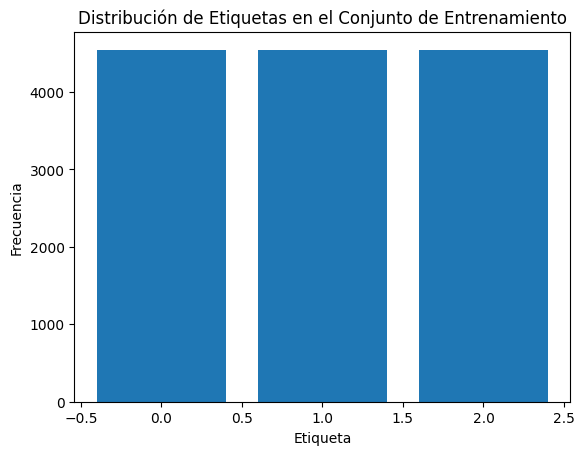

In [10]:
## DISTRIBUCIÓN DE ETIQUETAS
# Recuento de cada etiqueta (label) para ver si el dataset está balanceado.
label_counts = Counter(ds_tarea['train']['label'])
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Etiqueta')
plt.ylabel('Frecuencia')
plt.title('Distribución de Etiquetas en el Conjunto de Entrenamiento')
plt.show()

In [11]:
# VERIFICACIÓN DE VALORES NULOS EN EL CONJUNTO DE ENTRENAMIENTO
null_premise = sum([1 for x in ds_tarea['train']['premise'] if x is None])
null_hypothesis = sum([1 for x in ds_tarea['train']['hypothesis'] if x is None])
print(f"Premise tiene {null_premise} valores nulos")
print(f"Hypothesis tiene {null_hypothesis} valores nulos")

Premise tiene 0 valores nulos
Hypothesis tiene 0 valores nulos


## Model y Tokenizer

Se pide guardar el modelo y el tokenizador en las variables _model_ y _tokenizer_.
Aunque no se utilicen hasta más adelante, declaradlos en esta sección.

In [12]:
tokenizer = None
model = None

### BEGIN SOLUTION
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "distilbert-base-uncased"

# Cargar el tokenizador y el modelo
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

### END SOLUTION

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Feature Engineering

Si tenéis que realizar alguna modificación de los datos (no siempre es necesaria, pero algunos modelos preentrenados lo piden), podéis utilizar esta sección.

Al finalizar la sección, bien si modificais el DatasectDict, bien si no lo modificáis, lo guardaréis en __ds_tarea_featured__.

In [13]:
# Celdas de libre uso

In [14]:
# ds_tarea_featured = ds_tarea # Esta línea tiene sentido en caso de que no se modifique el dataset

### BEGIN SOLUTION

# Definir la función de preprocesamiento
def preprocess_function(examples):
    return tokenizer(examples['premise'], examples['hypothesis'], truncation=True, padding='max_length', max_length=128, return_tensors='pt')

# Aplicar la función de preprocesamiento al dataset
ds_tarea_featured = ds_tarea.map(preprocess_function, batched=True)

### END SOLUTION

ds_tarea_featured

Map:   0%|          | 0/413 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 13635
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx', 'input_ids', 'attention_mask'],
        num_rows: 413
    })
})

In [15]:
# Celda de control

assert len(ds_tarea_featured['train']) == 13635
assert len(ds_tarea_featured['validation_matched']) == 413

## Fine-tuning

Para poder evaluar el modelo a lo largo del proceso y no esperar a tener toda la ejecución completa (que podría durar horas), se propone la creación de una métrica que muestre por pantalla la evolución del entrenamiento.

Esta métrica se declara en una función, llamada en este caso _compute_metrics_ y se le pide a los argumentos y al trainer que calculen la métrica al final de cada _epoch_ con el _evaluation_dataset_.

In [16]:
from datasets import load_metric

def compute_metrics(eval_pred):
    metric = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels)

A continuación, de forma libre se pide entrenar un modelo de HuggingFace deseado. Se pide usar un Trainer de HuggingFace que tenga los siguientes argumentos como mínimo (puede haber más argumentos en todas las variables):

In [17]:
#!pip install transformers[torch]

In [18]:
#!pip install accelerate -U

In [19]:
from transformers import TrainingArguments, Trainer

### BEGIN SOLUTION

# Definir los argumentos de entrenamiento
args = TrainingArguments(
    output_dir='./finetuned1',   # Directorio para guardar los resultados
    evaluation_strategy="epoch", # Evaluar al final de cada época
    save_strategy="epoch",       # Guardar el modelo al final de cada época
    per_device_train_batch_size=16, # Tamaño del batch de entrenamiento
    per_device_eval_batch_size=16,  # Tamaño del batch de evaluación
    num_train_epochs=3,             # Número de épocas de entrenamiento
    learning_rate=2e-5,             # Tasa de aprendizaje
    weight_decay=0.01,              # Decaimiento del peso
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=ds_tarea_featured["train"],
    eval_dataset=ds_tarea_featured["validation_matched"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

### END SOLUTION

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


A continuación se entrena el modelo. Se pide no modificar esta celda, solo ejecutar.

In [20]:
# Esta celda, celda tiene que estar ejecutada en la entrega

from time import time

start = time()

trainer.train()

end = time()
print(f">>>>>>>>>>>>> elapsed time: {(end-start)/60:.0f}m")

Epoch,Training Loss,Validation Loss,Accuracy
1,0.880200,0.609740,0.716707
2,0.553000,0.560424,0.774818
3,0.421500,0.586886,0.779661


<ipython-input-16-3b44ea28a3f1>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y
>>>>>>>>>>>>> elapsed time: 9m


In [21]:
# Esta celda tiene que estar ejecutada en la entrega
# Se espera un eval_accuracy superior a 0.75
# A mayor accuracy no hay mayor nota, con superar el umbral de 0.75 es suficiente

results = trainer.evaluate()
final_eval_accuracy = results.get("eval_accuracy")

print(f"Final Eval Accuracy: {final_eval_accuracy:.2f}")

Final Eval Accuracy: 0.78
